# Installation des packages:

In [1]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

# Only for installation if not installed yet
#BiocManager::install("limma")
#BiocManager::install("mixOmics")
#BiocManager::install("edgeR")
#BiocManager::install("HTSFilter")

#install.packages("Rcpp")
#install.packages("magrittr") # package installations are only needed the first time you use it
#install.packages("dplyr")    # alternative installation of the %>%

#install.packages("plyr")
#install.packages("questionr")
#install.packages("hdv2003")
#install.packages("rp99")
#install.packages("fecondite")

# Librairies:

In [2]:
## Loading required package: limma
library(limma)
library(RColorBrewer)
library(ggplot2)
library(edgeR)
library(Matrix)
library(plyr)
library(magrittr) # needs to be run every time you start R and want to use %>%
library(Rcpp)
library(dplyr)    # alternatively, this also loads %>%
library(mixOmics)
library(HTSFilter)

# First reading the data
#The root directory
dir="."
setwd(dir)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: lattice


Loaded mixOmics 6.8.5
Thank you for using mixOmics!
Tutorials: http://mixomics.org
Bookdown vignette: https://mixomicsteam.github.io/Bookdown
Questions, issues: Follow the prompts at http://mixomics.org/contact-us
Cite us:  citation('mixOmics')




In [3]:
# Table containing circRNAs names and corresponding gene_id:
GeneData=read.table("../exonic_comparison_all.tsv", col.names=c("circRNA", "gene_id", "biotype"), sep="\t")
GeneData=distinct(GeneData,circRNA,gene_id)

# Deletion of duclicated rows (if several gene_id found for one circRNA):
GeneData <- GeneData %>% group_by(circRNA) %>% add_tally() %>% filter(n==1) 
GeneData$n <- NULL
GeneData <- data.frame(GeneData, row.names = GeneData$circRNA)

# Table containing PIG data : the nb of CCR by individuals:
PigData=read.table("../cirRNAcounts_pig_exonic.tsv", header=T, sep="\t")
PigData=aggregate(PigData[,-1], list(circRNA=PigData[,1]), FUN = sum)
names(PigData)[1] <- ""
PigData = data.frame(PigData[,-1], row.names = PigData[,1])

# Reorder column names:
col_order_pig <- c("pig.testis.Testis.05", "pig.testis.Testis.16", "pig.testis.Testis.54", "pig.testis.Testis.65", "pig.testis.Testis.73", "pig.testis.Testis.91",
                   "pig.liver.old.1", "pig.liver.old.2", "pig.liver.young.1", "pig.liver.young.2")

# Add gene_id for each circRNAs by merging the PigData and GeneData tables:
PigData <- PigData[, col_order_pig]
#PigData = cbind(PigData, GeneData[rownames(PigData), 2])
#colnames(PigData)[ncol(PigData)] <- colnames(GeneData)[2]
#head(PigData)

# Table containing COW data : the nb of CCR by individuals::
CowData=read.table("../cirRNAcounts_cow_exonic.tsv", header=T, sep="\t")
CowData=aggregate(CowData[,-1], list(circRNA=CowData[,1]), FUN = sum)
CowData = data.frame(CowData[,-1], row.names = CowData[,1])

# Reorder column names:
col_order_cow <- c("cow.testis.adult.1", "cow.testis.adult.2", "cow.testis.adult.3",
                   "cow.testis.neonat.1", "cow.testis.neonat.2", "cow.testis.neonat.3", 
                   "cow.liver.B004", "cow.liver.B005", "cow.liver.B008", "cow.liver.B022", "cow.liver.B027", "cow.liver.B028",
                   "cow.liver.K001", "cow.liver.K006", "cow.liver.K011", "cow.liver.K013", "cow.liver.K018", "cow.liver.K024")

# Add gene_id for each circRNAs by merging the CowData and GeneData tables:
CowData <- CowData[, col_order_cow]
#CowData = cbind(CowData, GeneData[rownames(CowData), 2])
#colnames(CowData)[ncol(CowData)] <- colnames(GeneData)[2]
#head(CowData)

In [4]:
# Using nb_ccr per indivivual for representation purpose only

# Normalisation TC : NB / Sum(colonne) * Moy(Sum(colonnes))

pseudoCountsCow = apply(CowData,2,function(x){(x/sum(x))*mean(apply(CowData,2,sum))
})
head(pseudoCountsCow)
pseudoCountsPig = apply(PigData,2,function(x){(x/sum(x))*mean(apply(PigData,2,sum))
})
head(pseudoCountsPig)

,cow.testis.adult.1,cow.testis.adult.2,cow.testis.adult.3,cow.testis.neonat.1,cow.testis.neonat.2,cow.testis.neonat.3,cow.liver.B004,cow.liver.B005,cow.liver.B008,cow.liver.B022,cow.liver.B027,cow.liver.B028,cow.liver.K001,cow.liver.K006,cow.liver.K011,cow.liver.K013,cow.liver.K018,cow.liver.K024
1:100113673-100145980:+,0.00000,5.638332,0.000000,0.000000,0.000000,0.000000,0.00000,0,0,0,0,0,0,0,0,0,0,0
1:10360227-10362943:+,20.04523,4.933541,10.827187,24.028080,32.515690,20.285634,15.32259,0,0,0,0,0,0,0,0,0,0,0
1:10418537-10446067:+,0.00000,0.000000,0.000000,0.000000,3.825375,0.000000,0.00000,0,0,0,0,0,0,0,0,0,0,0
1:10421279-10446067:+,0.00000,0.000000,0.000000,0.000000,2.869031,2.535704,0.00000,0,0,0,0,0,0,0,0,0,0,0
1:10434728-10446067:+,0.00000,0.000000,0.000000,7.762918,10.997954,5.916643,0.00000,0,0,0,0,0,0,0,0,0,0,0
1:10434728-10473430:+,0.00000,0.000000,5.413593,0.000000,0.000000,3.803556,0.00000,0,0,0,0,0,0,0,0,0,0,0


,pig.testis.Testis.05,pig.testis.Testis.16,pig.testis.Testis.54,pig.testis.Testis.65,pig.testis.Testis.73,pig.testis.Testis.91,pig.liver.old.1,pig.liver.old.2,pig.liver.young.1,pig.liver.young.2
1:100589849-100597672:+,3.796392,0.000000,0.00000,0.00000,6.077580,11.76961,0.00000,7.135998,0.00000,0.0000
1:100589849-100603238:+,3.796392,6.444236,0.00000,11.32993,5.209354,0.00000,0.00000,0.000000,0.00000,0.0000
1:100589849-100613174:+,34.709869,24.856337,33.34487,55.23339,41.674832,32.59278,28.81547,53.519986,36.79438,36.9434
1:100597459-100613174:+,3.254050,0.000000,0.00000,0.00000,0.000000,7.24284,0.00000,0.000000,0.00000,0.0000
1:10070671-10175846:-,8.135126,12.888471,16.67244,31.15729,5.209354,19.01245,123.90651,159.370626,215.50993,121.5557
1:10175651-10175846:-,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,14.45493,0.0000


In [5]:
# Using logarithm for representation purpose only
pseudoCountsCow <- log2(pseudoCountsCow+1)
head(pseudoCountsCow)
pseudoCountsPig <- log2(pseudoCountsPig+1)
head(pseudoCountsPig)

,cow.testis.adult.1,cow.testis.adult.2,cow.testis.adult.3,cow.testis.neonat.1,cow.testis.neonat.2,cow.testis.neonat.3,cow.liver.B004,cow.liver.B005,cow.liver.B008,cow.liver.B022,cow.liver.B027,cow.liver.B028,cow.liver.K001,cow.liver.K006,cow.liver.K011,cow.liver.K013,cow.liver.K018,cow.liver.K024
1:100113673-100145980:+,0.000000,2.730821,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0
1:10360227-10362943:+,4.395421,2.568893,3.564035,4.645476,5.066765,4.411808,4.028798,0,0,0,0,0,0,0,0,0,0,0
1:10418537-10446067:+,0.000000,0.000000,0.000000,0.000000,2.270641,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0
1:10421279-10446067:+,0.000000,0.000000,0.000000,0.000000,1.951972,1.821998,0.000000,0,0,0,0,0,0,0,0,0,0,0
1:10434728-10446067:+,0.000000,0.000000,0.000000,3.131411,3.584716,2.790072,0.000000,0,0,0,0,0,0,0,0,0,0,0
1:10434728-10473430:+,0.000000,0.000000,2.681133,0.000000,0.000000,2.264103,0.000000,0,0,0,0,0,0,0,0,0,0,0


,pig.testis.Testis.05,pig.testis.Testis.16,pig.testis.Testis.54,pig.testis.Testis.65,pig.testis.Testis.73,pig.testis.Testis.91,pig.liver.old.1,pig.liver.old.2,pig.liver.young.1,pig.liver.young.2
1:100589849-100597672:+,2.261950,0.000000,0.000000,0.000000,2.823256,3.674643,0.000000,3.024319,0.000000,0.000000
1:100589849-100603238:+,2.261950,2.896124,0.000000,3.624092,2.634443,0.000000,0.000000,0.000000,0.000000,0.000000
1:100589849-100613174:+,5.158251,4.692446,5.102023,5.813355,5.415314,5.070079,4.897989,5.768713,5.240100,5.245777
1:100597459-100613174:+,2.088837,0.000000,0.000000,0.000000,0.000000,3.043141,0.000000,0.000000,0.000000,0.000000
1:10070671-10175846:-,3.191425,3.795816,4.143429,5.007074,2.634443,4.322826,6.964705,7.325266,7.758289,6.937294
1:10175651-10175846:-,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.949996,0.000000


In [ ]:
# Keeping only males
#CountTableCow = CountTableCow %>%
                #select_if(!grepl("K", names(.)))

[1] TRUE

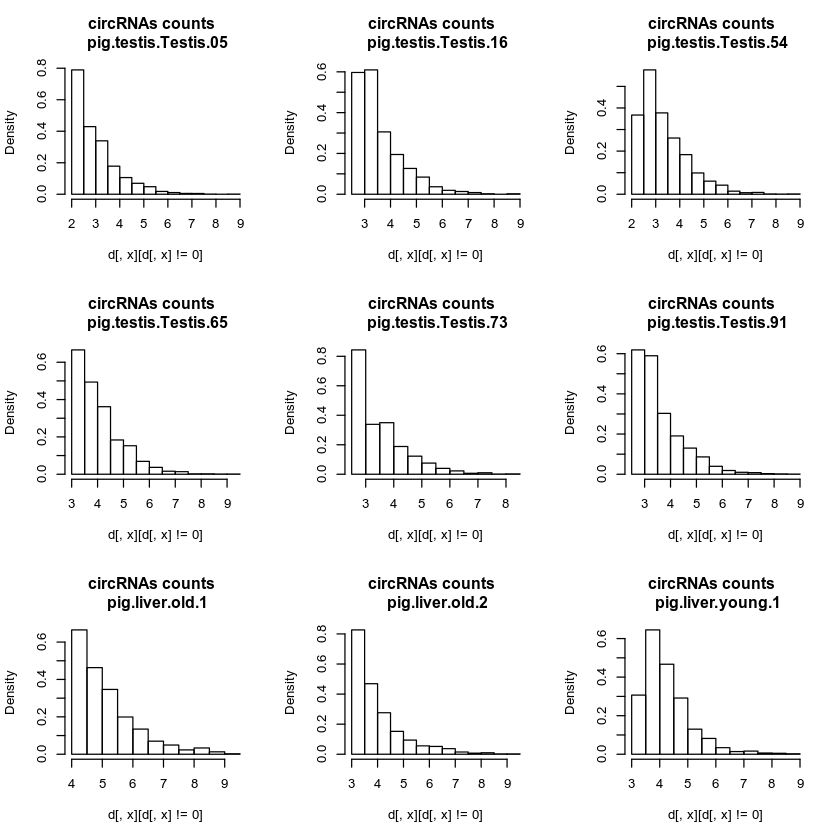

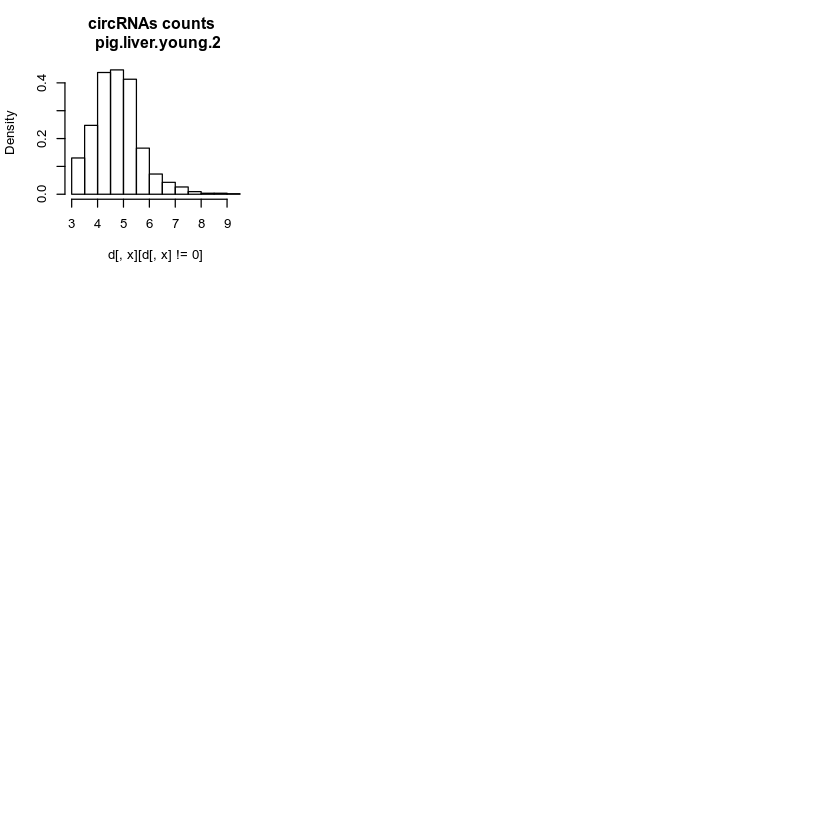

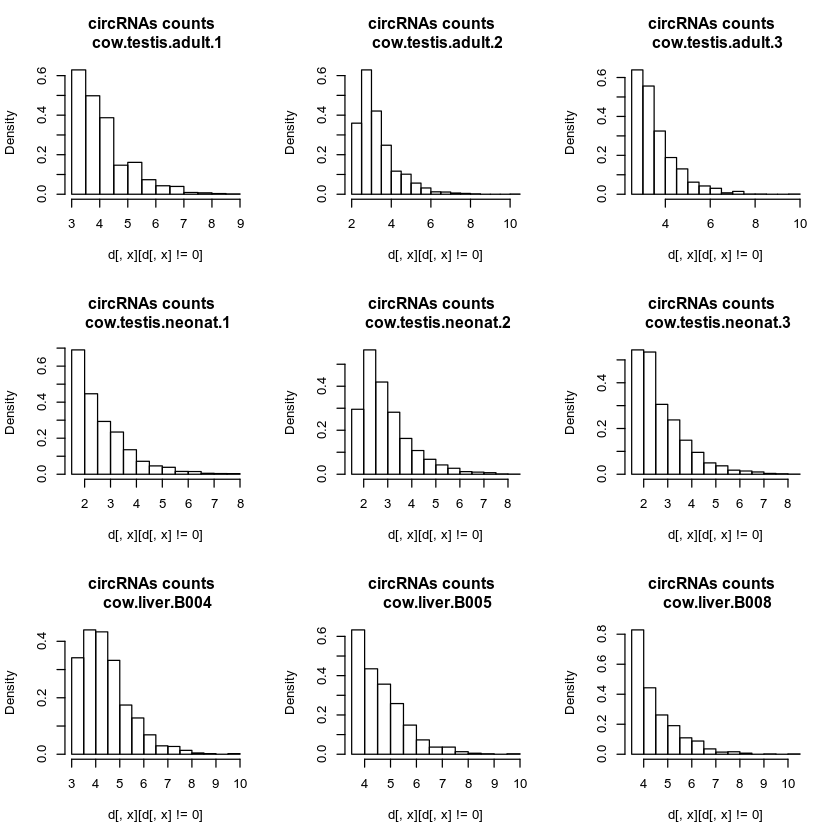

[1] TRUE

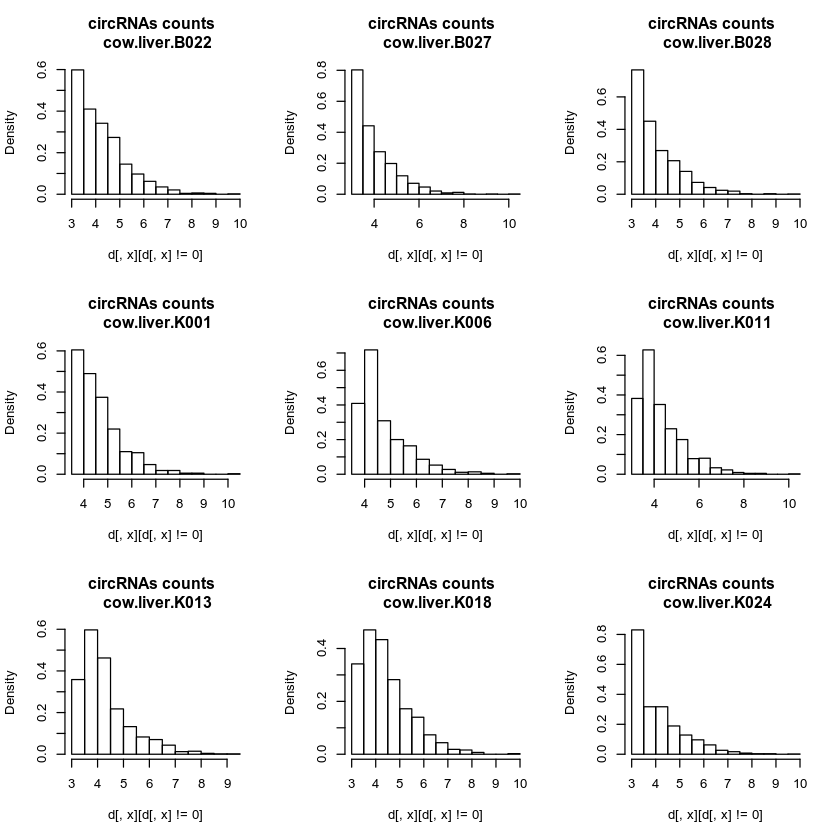

In [6]:
# Just to have an idea of circRNA counts
# circRNA with 0 counts are simmy not observed in the tissue under study
# rows = 5, cols = 2

densiteCCR <- function(d, rows=3, cols=3){
        
    par(mfrow=c(rows, cols))
    
    lapply(colnames(d), function(x){      
        # histo
        hist(d[,x][d[,x]!=0], main=paste("circRNAs counts ","\n", x), prob=TRUE)
    })
    
    return(TRUE);
}

densiteCCR(pseudoCountsPig)
densiteCCR(pseudoCountsCow)

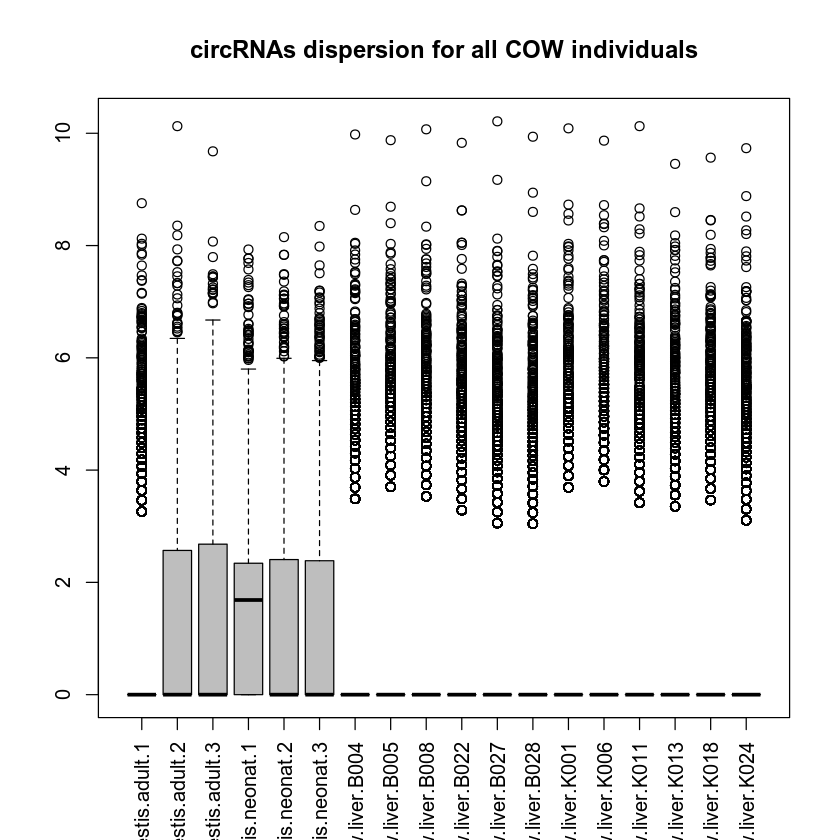

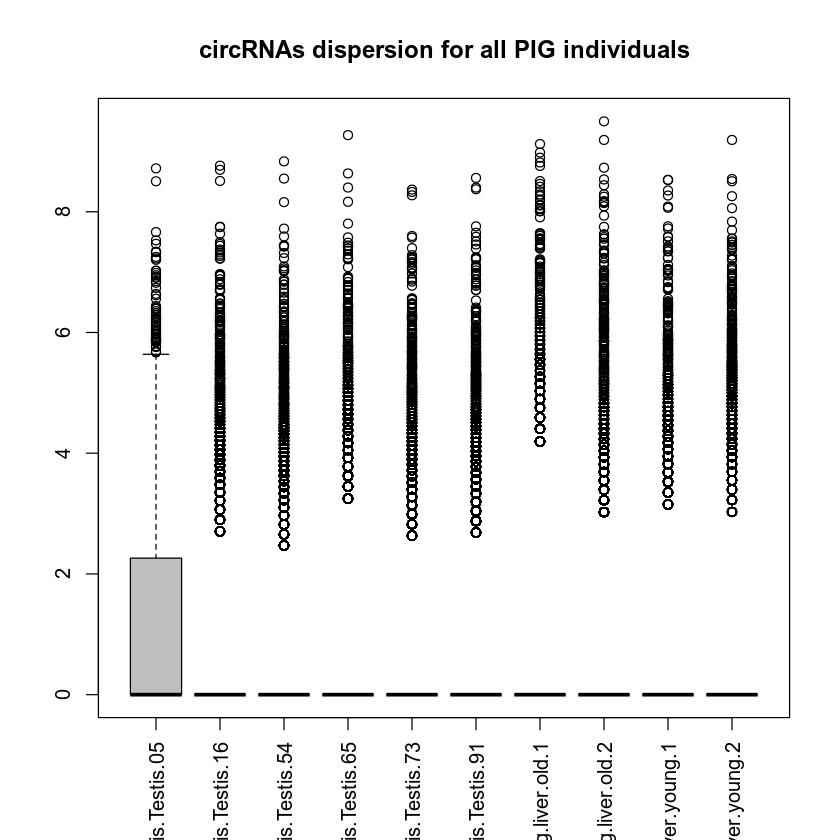

In [7]:
# Here the dispersion for all individuals

boxplot(pseudoCountsCow, col="gray", las=3, main="circRNAs dispersion for all COW individuals")
boxplot(pseudoCountsPig, col="gray", las=3, main="circRNAs dispersion for all PIG individuals")

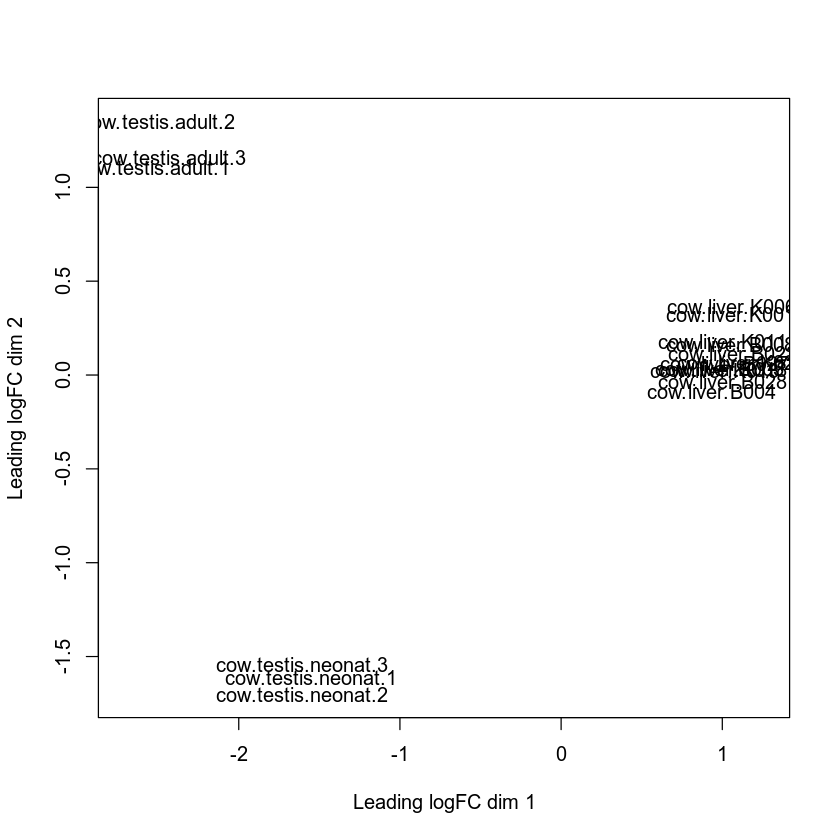

[1] 1622.3710 1037.2032  625.7863  546.3924  418.9679  276.8136  224.8799
 [8]  194.2227  159.7555  148.8143  145.1547  129.7751  122.1481  115.9219
[15]  111.9755  107.9463  101.8716

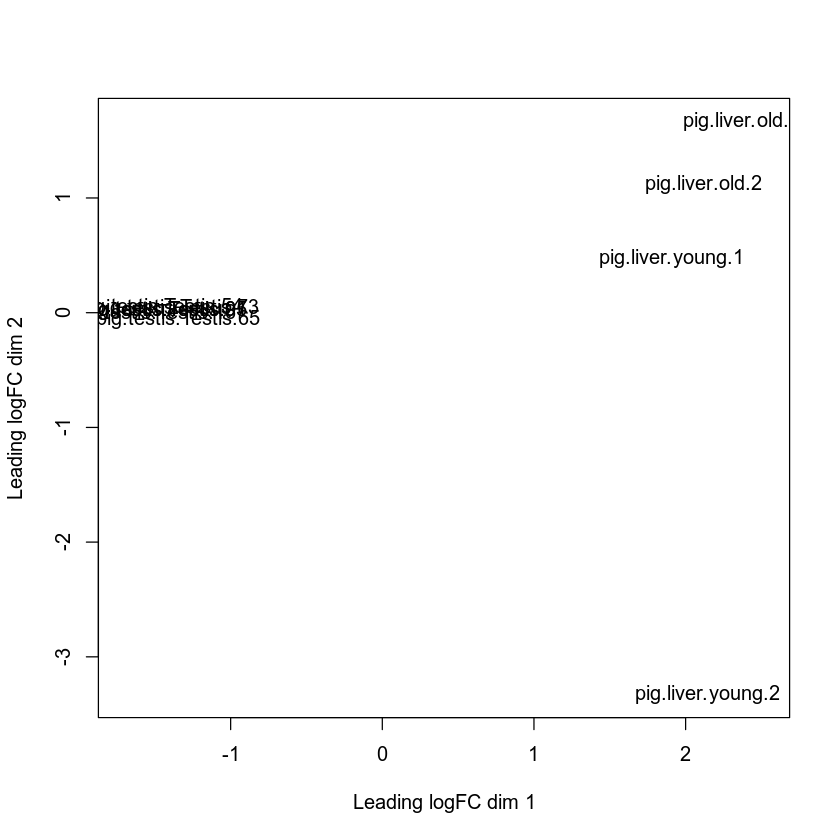

[1] 0.2663992

[1] 2090.0754  998.5529  933.8130  792.0149  624.9933  583.1322  526.0104
[8]  498.4062  424.0018

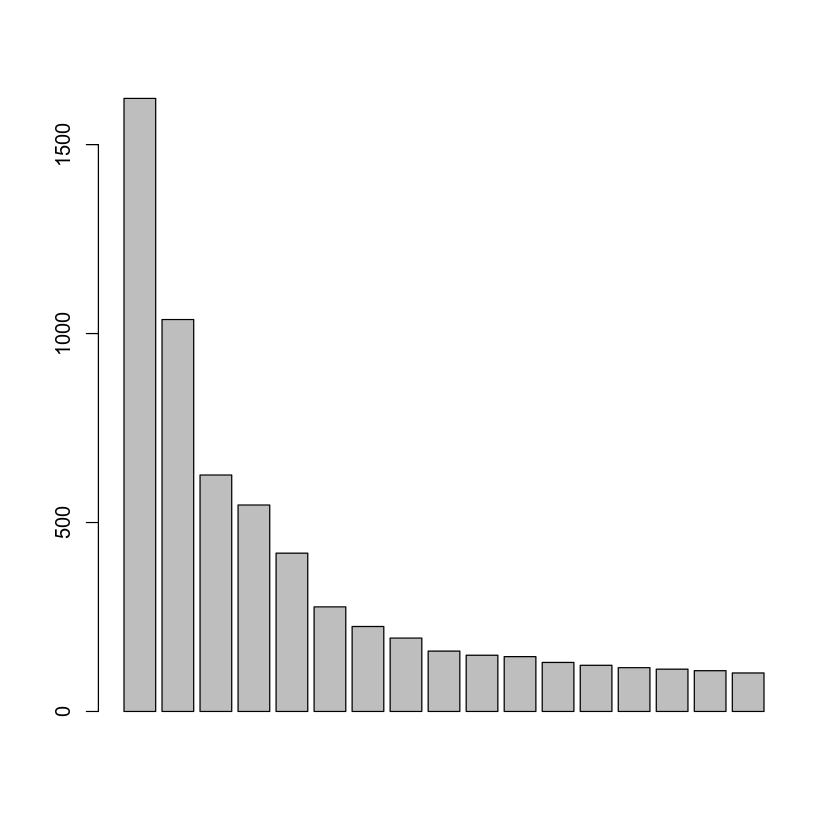

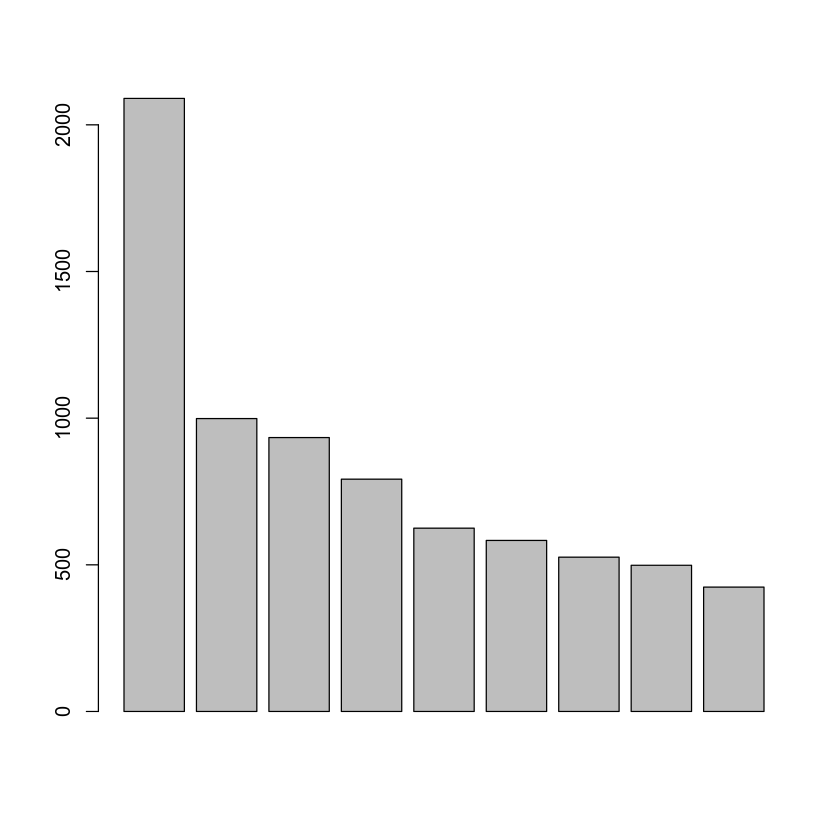

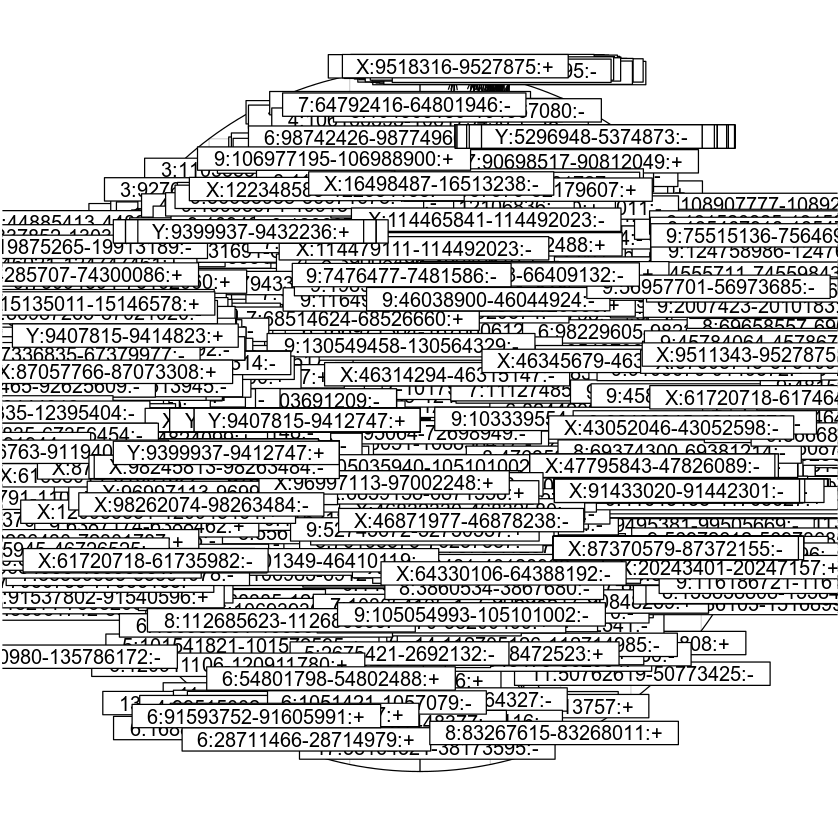

In [11]:
# MDS is simply another flavor of PCA (we can exchange on this point)
# Note the great separation of tissues and of age for testis
library(ade4)

plotMDS(pseudoCountsCow)
plotMDS(pseudoCountsPig)

#install.packages("factoextra")

res.pca.cow <- dudi.pca(t(pseudoCountsCow), scannf=FALSE, nf=2)
res.pca.cow$eig
barplot(res.pca.cow$eig)

axe1 = res.pca.cow$eig[1]/sum(res.pca.cow$eig) 
axe1

res.pca.pig <- dudi.pca(t(pseudoCountsPig), scannf=FALSE, nf=2)
res.pca.pig$eig
barplot(res.pca.pig$eig)

In [34]:
#For the purpose of differential expression we have to provide a distinction between two conditions: 
# here liver and testis

# COW:
namesCow = colnames(pseudoCountsCow)
x = strsplit(namesCow, "\\.")

conditions_cow = c()
for (i in x) {
    conditions_cow = append(conditions_cow, i[2])
}

sampleInfoCow <- matrix(conditions_cow,ncol=1,byrow=TRUE)
colnames(sampleInfoCow) <- c("condition")
rownames(sampleInfoCow) <- namesCow
sampleInfoCow <- as.table(sampleInfoCow)

write.table(sampleInfoCow, file='design.tsv', quote=FALSE, sep='\t')
sampleInfoCow <- read.table("design.tsv", header=TRUE,row.names=1)
sampleInfoCow

# PIG:
namesPig = colnames(pseudoCountsPig)
x = strsplit(namesPig, "\\.")

conditions_pig = c()
for (i in x) {
    conditions_pig = append(conditions_pig, i[2])
}

sampleInfoPig <- matrix(conditions_pig,ncol=1,byrow=TRUE)
colnames(sampleInfoPig) <- c("condition")
rownames(sampleInfoPig) <- namesPig
sampleInfoPig <- as.table(sampleInfoPig)

write.table(sampleInfoPig, file='design.tsv', quote=FALSE, sep='\t')
sampleInfoPig <- read.table("design.tsv", header=TRUE,row.names=1)
sampleInfoPig

,condition
,<fct>
cow.testis.adult.1,testis
cow.testis.adult.2,testis
cow.testis.adult.3,testis
cow.testis.neonat.1,testis
cow.testis.neonat.2,testis
cow.testis.neonat.3,testis
cow.liver.B004,liver
cow.liver.B005,liver
cow.liver.B008,liver


,condition
,<fct>
pig.testis.Testis.05,testis
pig.testis.Testis.16,testis
pig.testis.Testis.54,testis
pig.testis.Testis.65,testis
pig.testis.Testis.73,testis
pig.testis.Testis.91,testis
pig.liver.old.1,liver
pig.liver.old.2,liver
pig.liver.young.1,liver


In [ ]:
# Keeping only males
#sampleInfo = sampleInfo %>% filter(!grepl("K",row.names(sampleInfo)))

In [35]:
# Here we prepare the differential expression analysis
dgeFullCow <- DGEList(CowData, group=sampleInfoCow$condition)
dgeFullCow$sampleInfoCow <- sampleInfoCow

dgeFullPig <- DGEList(PigData, group=sampleInfoPig$condition)
dgeFullPig$sampleInfoPig <- sampleInfoPig

In [36]:
# Removing zero counts genes
dgeFullCow <- DGEList(dgeFullCow$counts[apply(dgeFullCow$counts, 1, sum) != 0, ],
                   group=dgeFullCow$samples$group)
head(dgeFullCow$counts)

dgeFullPig <- DGEList(dgeFullPig$counts[apply(dgeFullPig$counts, 1, sum) != 0, ],
                   group=dgeFullPig$samples$group)
head(dgeFullPig$counts)

,cow.testis.adult.1,cow.testis.adult.2,cow.testis.adult.3,cow.testis.neonat.1,cow.testis.neonat.2,cow.testis.neonat.3,cow.liver.B004,cow.liver.B005,cow.liver.B008,cow.liver.B022,cow.liver.B027,cow.liver.B028,cow.liver.K001,cow.liver.K006,cow.liver.K011,cow.liver.K013,cow.liver.K018,cow.liver.K024
1:100113673-100145980:+,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1:10360227-10362943:+,14,7,12,65,68,48,9,0,0,0,0,0,0,0,0,0,0,0
1:10418537-10446067:+,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0
1:10421279-10446067:+,0,0,0,0,6,6,0,0,0,0,0,0,0,0,0,0,0,0
1:10434728-10446067:+,0,0,0,21,23,14,0,0,0,0,0,0,0,0,0,0,0,0
1:10434728-10473430:+,0,0,6,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0


,pig.testis.Testis.05,pig.testis.Testis.16,pig.testis.Testis.54,pig.testis.Testis.65,pig.testis.Testis.73,pig.testis.Testis.91,pig.liver.old.1,pig.liver.old.2,pig.liver.young.1,pig.liver.young.2
1:100589849-100597672:+,7,0,0,0,7,13,0,6,0,0
1:100589849-100603238:+,7,7,0,8,6,0,0,0,0,0
1:100589849-100613174:+,64,27,44,39,48,36,10,45,28,31
1:100597459-100613174:+,6,0,0,0,0,8,0,0,0,0
1:10070671-10175846:-,15,14,22,22,6,21,43,134,164,102
1:10175651-10175846:-,0,0,0,0,0,0,0,0,11,0


In [37]:
# We normalize the data in order to take into account the different overall number of reads between samples
dgeFullCow <- calcNormFactors(dgeFullCow, method="TMM")
eff.lib.size.Cow <- dgeFullCow$samples$lib.size*dgeFullCow$samples$norm.factors
normCountsCow <- sweep(dgeFullCow$counts, 2, eff.lib.size.Cow, "/")*10^6

dgeFullPig <- calcNormFactors(dgeFullPig, method="TMM")
eff.lib.size.Pig <- dgeFullPig$samples$lib.size*dgeFullPig$samples$norm.factors
normCountsPig <- sweep(dgeFullPig$counts, 2, eff.lib.size.Pig, "/")*10^6

# which is equivalent to normCounts <- cpm(dgeFull)
pseudoNormCountsCow <- log2(normCountsCow + 1)
pseudoNormCountsPig <- log2(normCountsPig + 1)

dgeFullCow <- estimateCommonDisp(dgeFullCow)
dgeFullCow <- estimateTagwiseDisp(dgeFullCow)

dgeFullPig <- estimateCommonDisp(dgeFullPig)
dgeFullPig <- estimateTagwiseDisp(dgeFullPig)

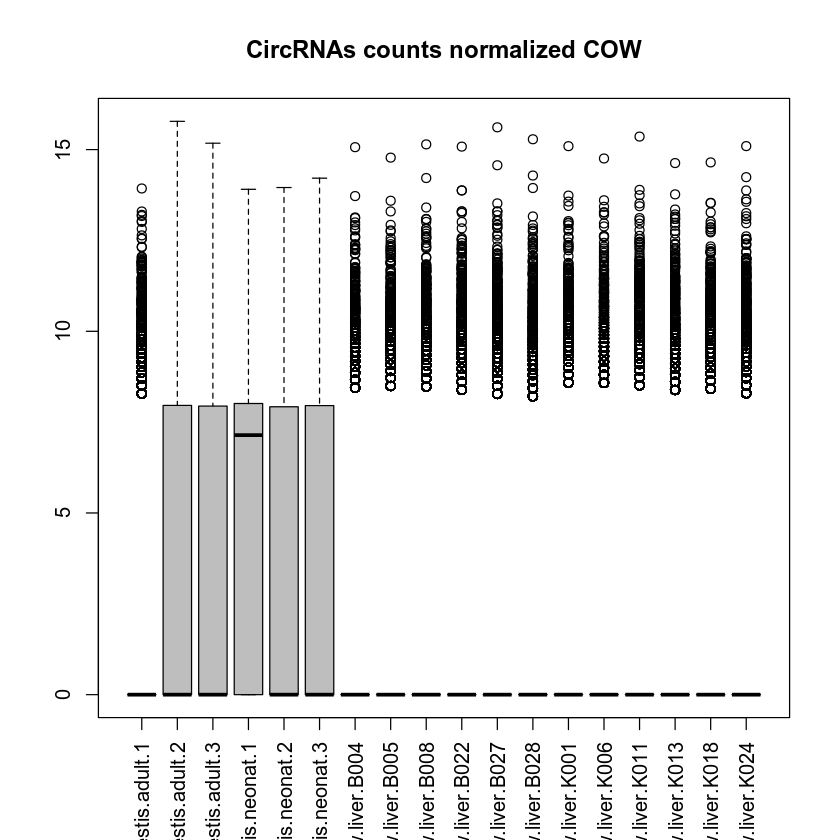

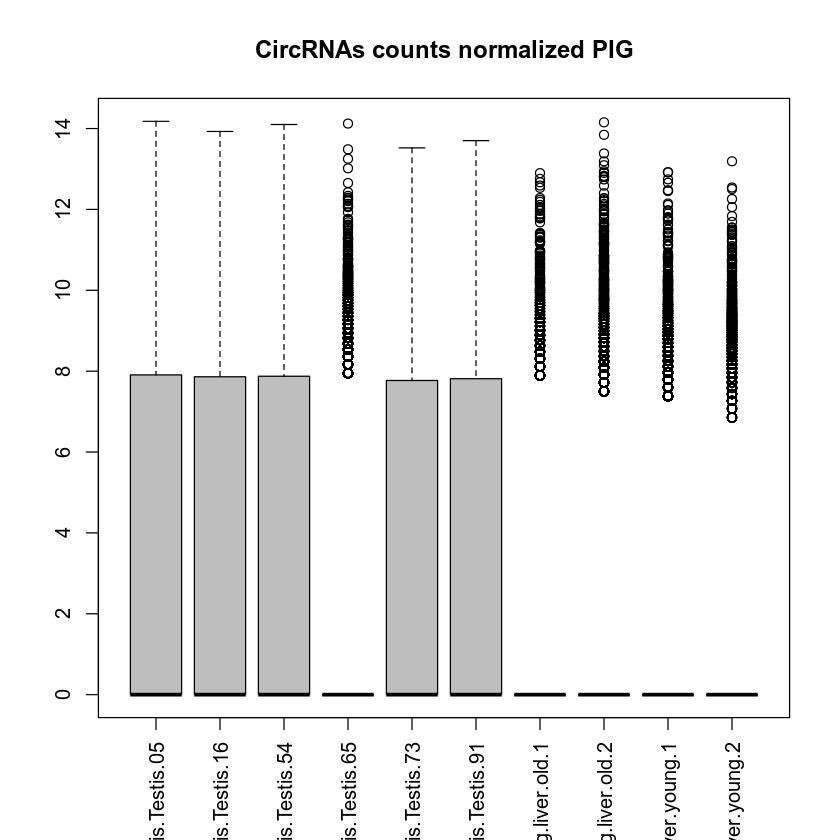

In [38]:
# boxplot after normalization
boxplot(pseudoNormCountsCow, col="gray", las=3,main="CircRNAs counts normalized COW")
boxplot(pseudoNormCountsPig, col="gray", las=3,main="CircRNAs counts normalized PIG")

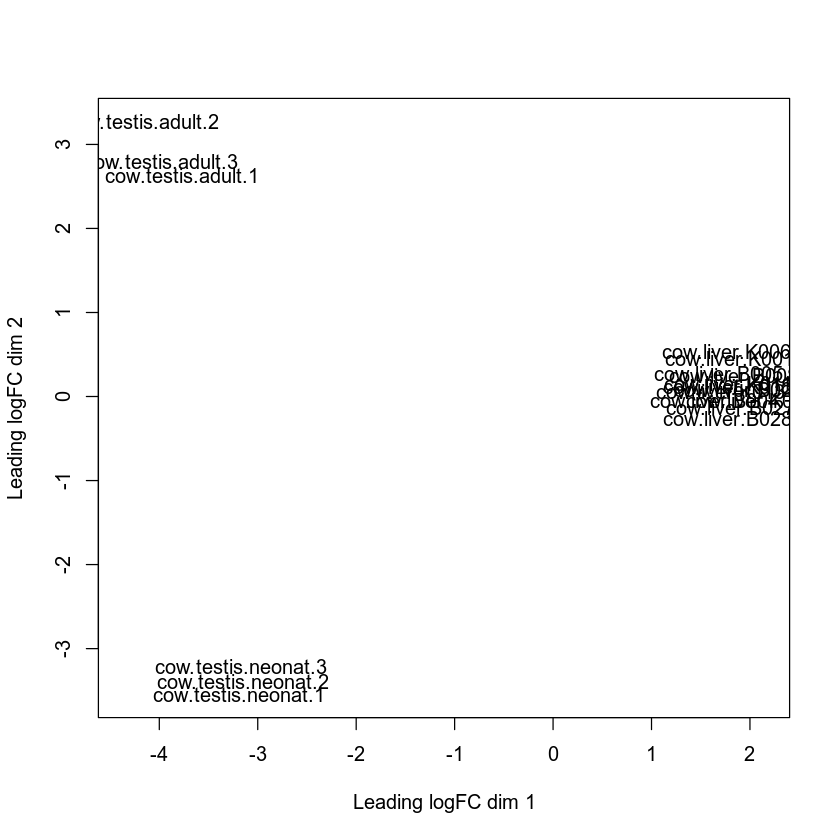

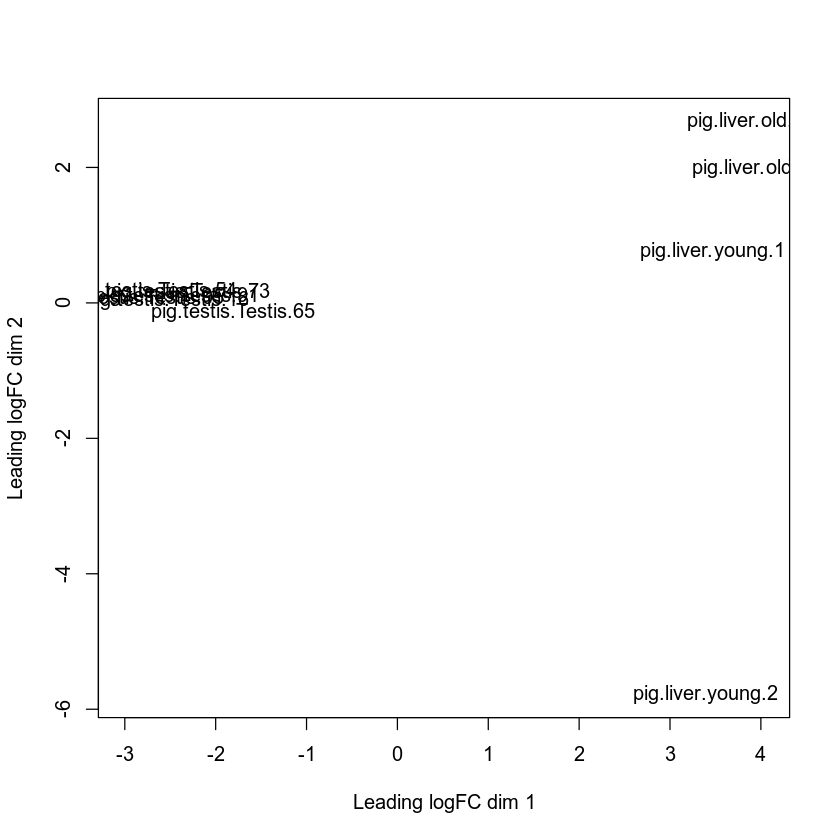

In [39]:
plotMDS(pseudoNormCountsCow)
plotMDS(pseudoNormCountsPig)

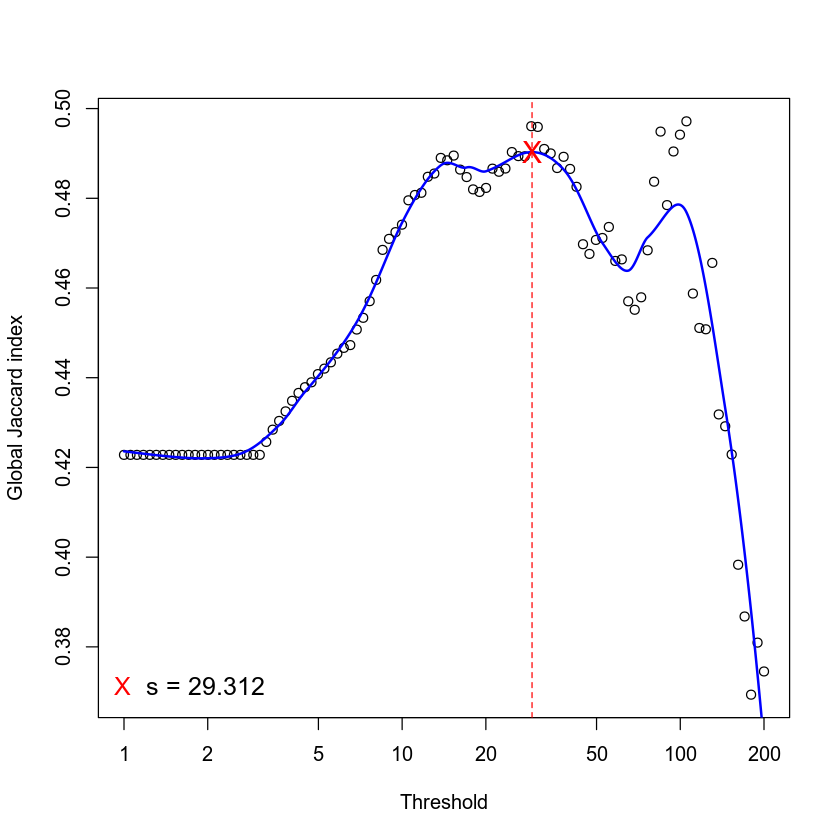

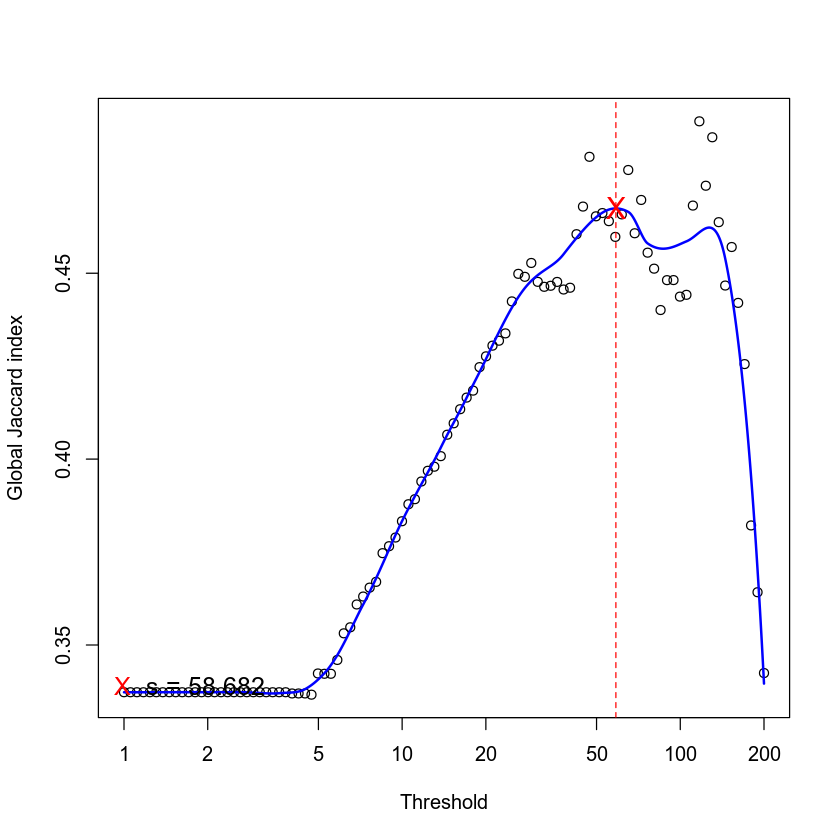

In [40]:
# Here this is simply a cooking recipe, don't pay attention...
filtDataCow <- HTSFilter(dgeFullCow)$filteredData
filtDataPig <- HTSFilter(dgeFullPig)$filteredData

In [41]:
# perform an exact test on filtered data
dgeTestFiltCow <- exactTest(filtDataCow,pair=c("liver","testis"))
dgeTestFiltPig <- exactTest(filtDataPig,pair=c("liver","testis"))

resFiltCow <- topTags(dgeTestFiltCow, n=nrow(dgeTestFiltCow$table))
resFiltPig <- topTags(dgeTestFiltPig, n=nrow(dgeTestFiltPig$table))

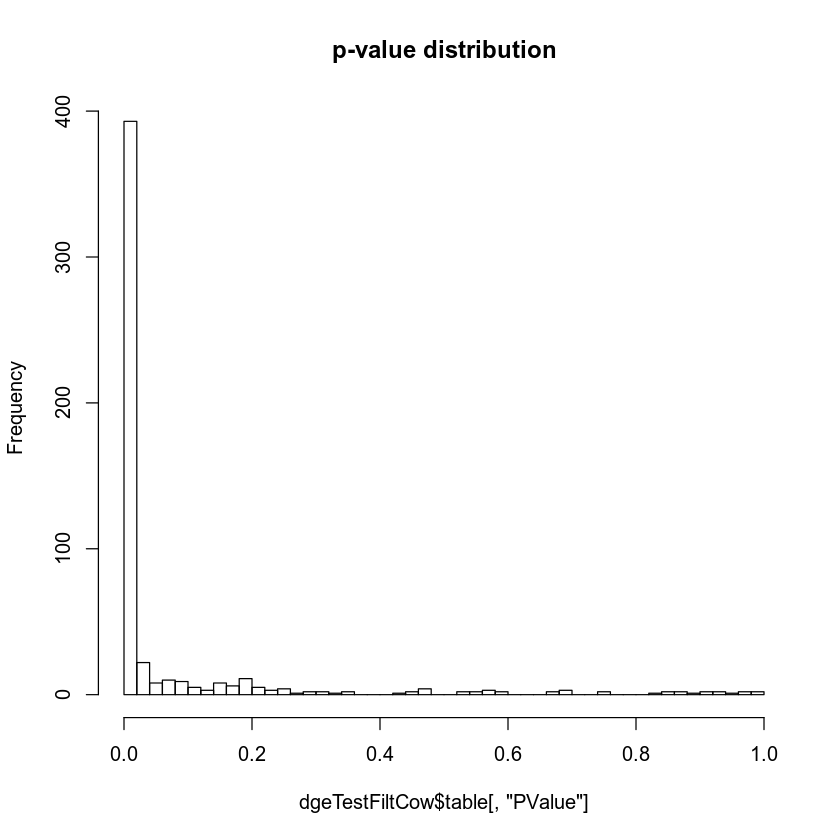

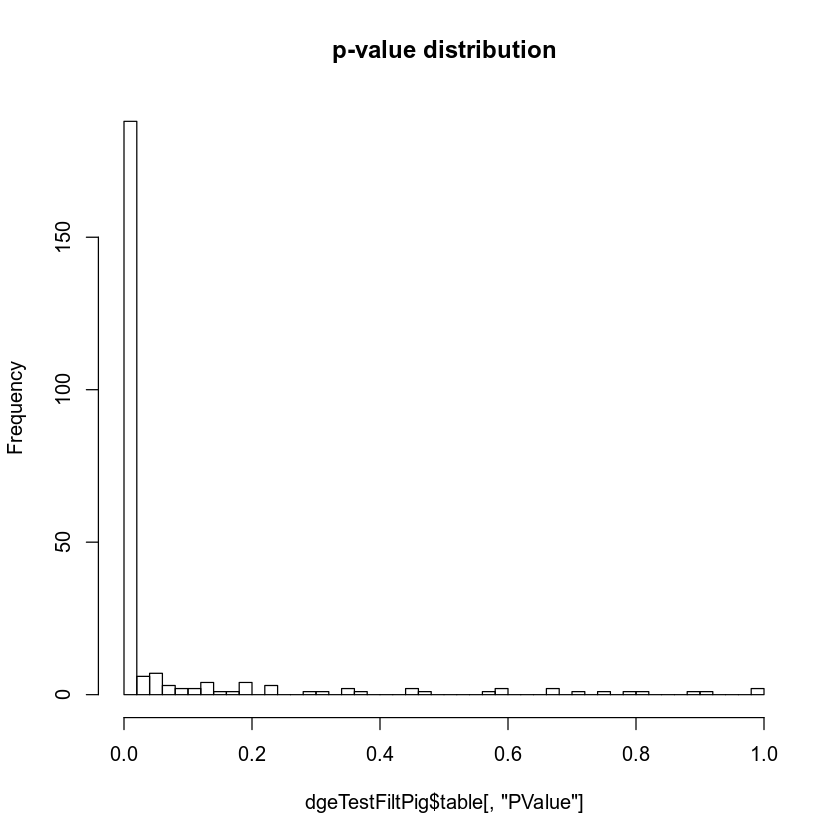

In [42]:
# plot a histogram of unadjusted p-values after filtering
hist(dgeTestFiltCow$table[,"PValue"], breaks=50,main="p-value distribution")
hist(dgeTestFiltPig$table[,"PValue"], breaks=50,main="p-value distribution")

In [43]:
# Number of circRNAs clearly differentially expressed btween tissue
sum(resFiltCow$table$FDR < 0.01)
sum(resFiltPig$table$FDR < 0.01)

[1] 357

[1] 182

In [44]:
resFiltFDRCow <- resFiltCow$table[resFiltCow$table$FDR<0.02,]
resFiltFDRPig <- resFiltPig$table[resFiltPig$table$FDR<0.02,]

In [45]:
sigDownRegCow <- resFiltFDRCow[order(resFiltFDRCow$logFC),]
head(sigDownRegCow)

sigDownRegPig <- resFiltFDRPig[order(resFiltFDRPig$logFC),]
head(sigDownRegPig)

,logFC,logCPM,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>
X:92407498-92421831:-,-12.595616,14.49459,3.730556e-105,1.988386e-102
6:88490915-88495003:+,-10.565866,12.48115,6.891511e-68,1.836588e-65
16:69562358-69577209:-,-10.512414,12.42847,1.171360e-55,2.081116e-53
6:88490915-88500819:+,-9.274206,11.21894,2.255977e-41,3.006089e-39
X:135476782-135533067:-,-9.270400,11.21584,8.258516e-25,1.294644e-23
14:60175681-60177587:+,-8.930813,10.88974,3.098760e-30,9.715525e-29


,logFC,logCPM,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>
13:22318658-22335113:+,-10.797376,11.379935,8.295957e-18,4.896638e-17
X:47818209-47826089:-,-10.568104,11.155284,2.285651e-34,1.843758e-32
18:24985701-25003037:+,-9.859395,10.468949,2.971396e-19,2.179024e-18
2:26502034-26518029:-,-9.590181,10.211255,6.291645e-25,1.268815e-23
13:135736997-135739109:-,-9.004746,9.662505,4.829736e-19,3.437636e-18
4:32828630-32833310:+,-8.865429,9.530252,3.717123e-17,2.044418e-16


In [46]:
sigUpRegCow <- resFiltFDRCow[order(resFiltFDRCow$logFC, decreasing=TRUE),]
head(sigUpRegCow)

sigUpRegPig <- resFiltFDRPig[order(resFiltFDRPig$logFC, decreasing=TRUE),]
head(sigUpRegPig)

,logFC,logCPM,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>
21:44945324-44948098:-,11.696912,12.611964,2.331662e-19,2.344860e-18
21:44946733-44948098:-,9.995267,10.956973,6.021045e-18,4.789876e-17
21:44942582-44948098:-,9.636963,10.617265,1.076469e-17,8.081102e-17
17:55575861-55605222:+,9.227689,10.233735,3.360820e-08,1.079107e-07
19:42832432-42834574:+,8.861646,9.898502,8.031398e-08,2.518080e-07
4:32301748-32313581:-,8.822913,9.865754,3.357879e-16,2.237187e-15


,logFC,logCPM,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>
4:95613285-95627346:+,12.049962,13.19406,1.782389e-46,4.313381e-44
9:89711256-89735776:+,10.288943,11.45327,1.164498e-37,1.409043e-35
10:24770315-24779098:-,10.278743,11.44186,8.918261e-28,2.697774e-26
4:6343202-6392035:-,9.992809,11.16397,1.502293e-29,6.059247e-28
4:36796976-36840800:-,9.743608,10.91967,1.135163e-24,1.831396e-23
12:1492106-1494267:+,9.736700,10.91409,3.701772e-31,2.239572e-29


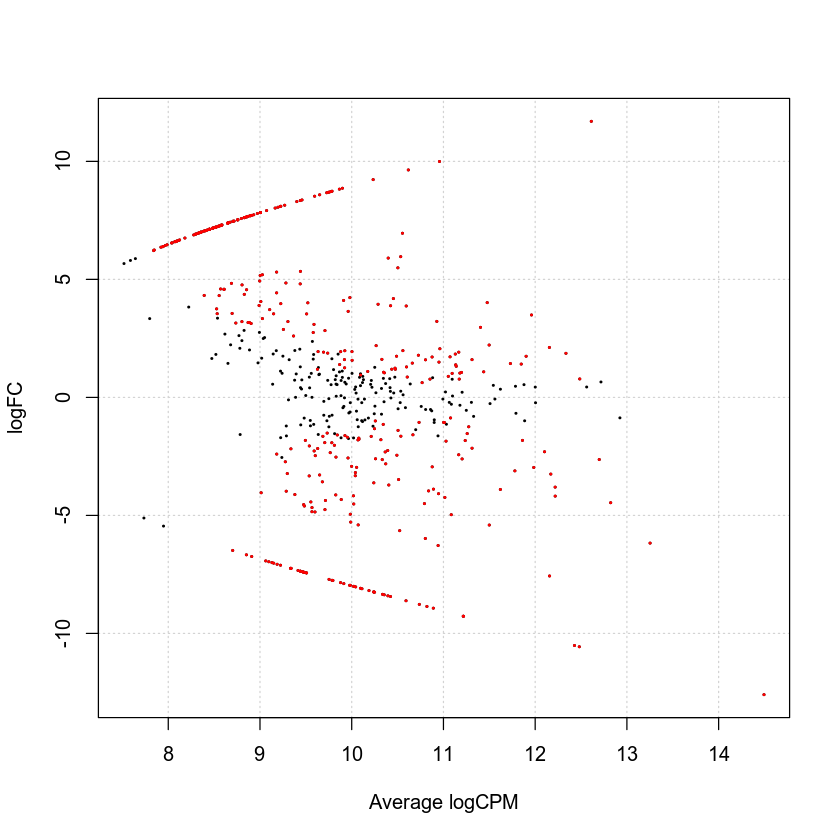

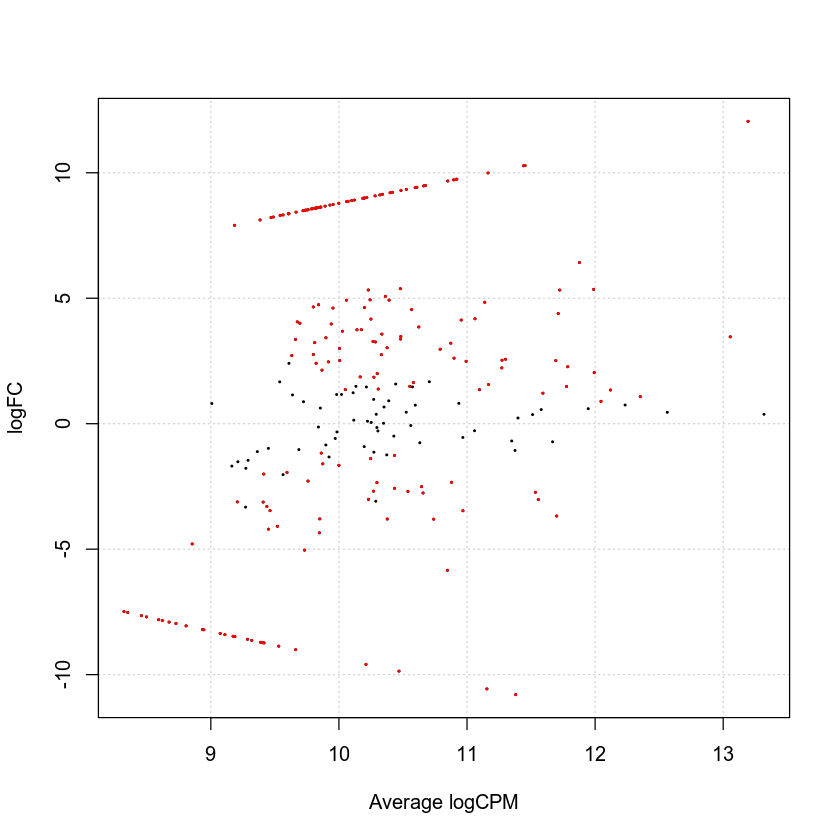

In [47]:
plotSmear(dgeTestFiltCow, de.tags = rownames(resFiltCow$table)[which(resFiltCow$table$FDR<0.01)])
plotSmear(dgeTestFiltPig, de.tags = rownames(resFiltPig$table)[which(resFiltPig$table$FDR<0.01)])

# Orthologie:

In [ ]:
OrthologData=read.table("cirRNAcounts_ortholog.tsv", header=T, sep="\t")
OrthologData=aggregate(OrthologData[,-1], list(circRNA=OrthologData[,1]), FUN = sum)
names(OrthologData)[1] <- ""
OrthologData = data.frame(OrthologData[,-1], row.names = OrthologData[,1])
CountTableOtholog = round(OrthologData) # necessary for gene counts provided by RSEM
head(OrthologData)

# Add gene_id for each circRNAs by merging the CowData and GeneData tables:
OrthologData = cbind(OrthologData, GeneData[rownames(OrthologData), 2])
colnames(OrthologData)[ncol(OrthologData)] <- colnames(GeneData)[2]
head(OrthologData)

In [ ]:
# Using logarithm for representation purpose only
pseudoCountsOrtholog <- log2(CountTableOtholog+1)
head(pseudoCountsOrtholog)